# Population Segmentation: first iteraion

## Objective

The objective of this notbook is to run our first population segmentation in order to:
- Explore the libraries
- Assess acuracy and how representative the data is for this task
- Assess the cost : time + hardware
- Use of **Pipline** implementation

## Preprocessing, Features, and model

### Load packages

In [1]:
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer
from sklearn import metrics

from sklearn.cluster import KMeans, MiniBatchKMeans

from utilities.load_tweets import load_tweets
from utilities.load_authors_data import load_authors_data


from time import time

import numpy as np

### Load the Data

In [55]:
path = "data/pan15/english/"
authors_data = load_authors_data(path)

authors_data['tweet_text'] = authors_data['tweets'].apply(lambda x:" ".join(x))


### Clean the Data

In [60]:
from utilities.clean_tweets import clean_tweets
authors_data['tweet_text_clean'] = authors_data['tweet_text'].apply(lambda text: clean_tweets(text))

### Extract Features : Term Frequency (NO IDF)

Extracting features from the training dataset using a sparse vectorizer

In [62]:
## tf features extraction parameters

lsa_n_components = 2 #Preprocess documents with latent semantic analysis for dimentionality reduction
minibatch = True #Use ordinary k-means algorithm (in batch mode)
use_idf = False #Disable Inverse Document Frequency feature weighting
use_hashing = False #Use a hashing feature vectorize
n_features = 10000 # Maximum number of features (dimensions) to extract from text.


t0 = time()

if use_hashing:
    if use_idf:
        # Perform an IDF normalization on the output of HashingVectorizer
        hasher = HashingVectorizer(n_features=n_features,
                                   stop_words='english', non_negative=True,
                                   norm=None, binary=False)
        vectorizer = make_pipeline(hasher, TfidfTransformer())
    else:
        vectorizer = HashingVectorizer(n_features=n_features,
                                       stop_words='english',
                                       non_negative=False, norm='l2',
                                       binary=False)
else:
    vectorizer = TfidfVectorizer(max_df=0.5, max_features=n_features,
                                 min_df=2, stop_words='english',
                                 use_idf= use_idf)

X = vectorizer.fit_transform(authors_data['tweet_text'])

print("done in %fs" % (time() - t0))
print("n_samples: %d, n_features: %d" % X.shape)


done in 0.170567s
n_samples: 152, n_features: 6914


In [63]:
X_clean = vectorizer.fit_transform(authors_data['tweet_text_clean'])
print("n_samples: %d, n_features: %d" % X_clean.shape)


n_samples: 152, n_features: 6797


## 1- Perform the Clustering on raw text data (X)

### A- Find the optimal K using elbow method:

In [46]:
Sum_of_squared_distances = []
K = range(1,20)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(X)
    Sum_of_squared_distances.append(km.inertia_)

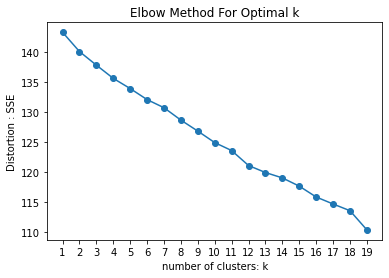

In [47]:
import matplotlib.pyplot as plt
plt.plot(K, Sum_of_squared_distances, marker='o')
plt.xticks(K)
plt.xlabel('number of clusters: k')
plt.ylabel('Distortion : SSE')
plt.title('Elbow Method For Optimal k')
plt.show()

### B- Observation

The Elbow method does not show any sharp decrease in the SSE as we increase the number of clusters

**Consider Clean text data**

## Perform Clustering on Clean Text Data (X_clean)

### A- Find the optimal K using elbow method:

In [48]:
Sum_of_squared_distances = []
K = range(1,20)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(X_clean)
    Sum_of_squared_distances.append(km.inertia_)

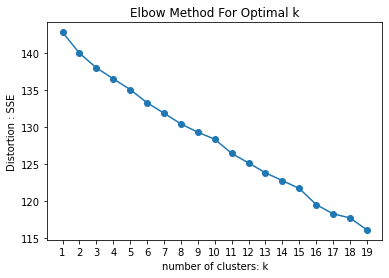

In [49]:
import matplotlib.pyplot as plt
plt.plot(K, Sum_of_squared_distances, marker='o')
plt.xticks(K)
plt.xlabel('number of clusters: k')
plt.ylabel('Distortion : SSE')
plt.title('Elbow Method For Optimal k')
plt.show()

### B- Observation

The Elbow method does not show any sharp decrease in the SSE as we increase the number of clusters

**Consider LSA Dimentionality reduction on clean data**

## Performing dimensionality reduction using LSA on clean text

In [52]:
t0 = time()
# Vectorizer results are normalized, which makes KMeans behave as
# spherical k-means for better results. Since LSA/SVD results are
# not normalized, we have to redo the normalization.

svd = TruncatedSVD(lsa_n_components)
lsa = make_pipeline(svd, Normalizer(copy=False))

X_lsa = lsa.fit_transform(X_clean)

print("done in %fs" % (time() - t0))

explained_variance = svd.explained_variance_ratio_.sum()
print("Explained variance of the SVD step: {}%".format(
    int(explained_variance * 100)))

done in 0.016103s
Explained variance of the SVD step: 3%


### Find the Optimal Number of clusters K

In [53]:
Sum_of_squared_distances = []
K = range(1,20)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(X_lsa)
    Sum_of_squared_distances.append(km.inertia_)

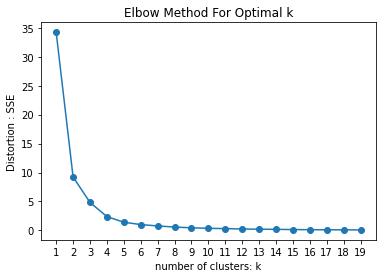

In [54]:
import matplotlib.pyplot as plt
plt.plot(K, Sum_of_squared_distances, marker='o')
plt.xticks(K)
plt.xlabel('number of clusters: k')
plt.ylabel('Distortion : SSE')
plt.title('Elbow Method For Optimal k')
plt.show()

### Observation

The best numbers of clusters is k=3